In [13]:
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from time import time
import numpy as np
import pylab as pl
import os


t0 = time()
# Load the data
filenames = []
for e in os.walk('./notMNIST_small'):
    filenames.append(e)
  
    
foldername = filenames[0][1] # ['A','G','E','F',...]


labels = foldername

filepath_dict = {foldername[i]:filenames[i+1][2]
                     for i,_ in enumerate(foldername)}

filepaths = defaultdict(list)
for key in filepath_dict.keys():
    filepaths[key] = [ os.path.join('./notMNIST_small',key,path) for path in filepath_dict[key]]
    
def imageData(key):
    '''input:key, output list of image data '''
    imagedata = []
    for e in filepaths[key]:
        try:
            imagedata.append(pl.imread(e))
        except:
            pass
    return np.array(imagedata)

images = {key:imageData(key) for key in filepaths.keys()} # images['A'] 

print 'time cost to read files: {}'.format(time()-t0)
size = 0
for i in labels:
    print "images[{}].shape = {}".format(i,images[i].shape)

    size += images[i].shape[0]

dataA = np.array([np.ndarray.flatten(images['A'][i]) for i in range(images['A'].shape[0])])

h = images['A'].shape[-1]
w = images['A'].shape[-2]
n_features = h*w


############################################

# prepare "data" for machine learn X,

# data.shape = (18724,28*28) 

# y -> label as (A,A,A....,G,G,H,H,H)

#      size as (18724,) 

############################################


data = np.zeros([size,n_features])
temp=0
y = np.chararray(size) # string numpy array


for j,label in enumerate(labels):
    for e in range(images[label].shape[0]):        
        data[temp] = np.ndarray.flatten(images[label][e])        
        y[temp]= np.array(label)
        temp += 1

X = data
n_samples = data.shape[0]
n_classes = len(labels)

print "Total datasets size"
print "==================="
print "n_samples: {}".format(n_samples)
print "n_features: {}".format(n_features)
print "n_classes: {}".format(n_classes)
print "==================="
###########################################

#

# split train/test for our original data

#

#######################


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
# fit model on all training data


time cost to read files: 2.61699986458
images[A].shape = (1872L, 28L, 28L)
images[B].shape = (1873L, 28L, 28L)
images[C].shape = (1873L, 28L, 28L)
images[D].shape = (1873L, 28L, 28L)
images[E].shape = (1873L, 28L, 28L)
images[F].shape = (1872L, 28L, 28L)
images[G].shape = (1872L, 28L, 28L)
images[H].shape = (1872L, 28L, 28L)
images[I].shape = (1872L, 28L, 28L)
images[J].shape = (1872L, 28L, 28L)
Total datasets size
n_samples: 18724
n_features: 784
n_classes: 10


Extracting the 150 eigenpixel from 784 pixels
done in 0.840s
Projecting the input data on the eigenimage orthonormal basis
done in 0.125s
Fitting the classifier to the training set
done in 122.061s
             precision    recall  f1-score   support

          A       0.90      0.90      0.90       454
          B       0.88      0.87      0.87       471
          C       0.91      0.93      0.92       472
          D       0.87      0.90      0.89       436
          E       0.90      0.88      0.89       502
          F       0.93      0.90      0.92       475
          G       0.87      0.88      0.87       458
          H       0.90      0.86      0.88       481
          I       0.86      0.87      0.86       467
          J       0.88      0.90      0.89       465

avg / total       0.89      0.89      0.89      4681

[[407   4   4   8   2   2   9   6   3   9]
 [  5 410   1  20  10   1   5  12   5   2]
 [  0   3 438   2   8   3  11   2   3   2]
 [  3  12   0 394   1   2   8   4 

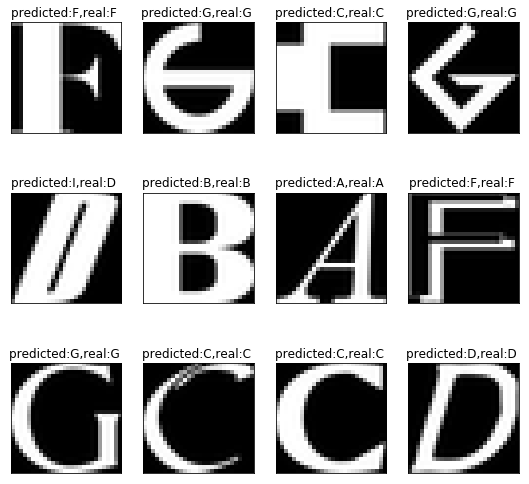

In [14]:
n_components = 150

print "Extracting the %d eigenpixel from %d pixels" % (n_components, X_train.shape[1])
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenimage = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenimage orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


################################

#

#  SVC and error analysis

#

################################


print "Fitting the classifier to the training set"
t0 = time()

clf = XGBClassifier(kernel='linear')
clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)

y_pred = clf.predict(X_test_pca)
print classification_report(y_test,y_pred)
print confusion_matrix(y_test,y_pred)

#################################

#

# plot 

#

################################


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of images"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

def title(y_pred,y_test,i):
    return 'predicted:{},real:{} '.format(y_pred[i],y_test[i])

prediction_titles = [title(y_pred, y_test,i) for i in range(12)]

plot_gallery(X_test[:12],prediction_titles,h,w)
pl.show()